In [22]:
# All required python standard libraries
import os
import time

In [23]:
# All torch related imports 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torch import nn, optim
import torchvision

In [86]:
# using cv2 to read an image
import cv2
# using matplotlib to plot image
import matplotlib.pyplot as plt

In [25]:
# All sci-kit related imports 
import pandas as pd
import numpy as np

In [26]:
from tqdm.notebook import tqdm as tq

In [58]:
IMAGE_DIMS = 28

In [59]:
def accuracy_finder(predictions , labels):
    values, max_indices = torch.max(predictions, dim=1)
    accuracy = ( max_indices == labels ).sum()
    return accuracy/max_indices.size()[0]

In [60]:
def csv_preprocessor(base_dir:str, directory:str):
    return os.path.join(base_dir,directory).replace("\\","/")

In [61]:
def return_all_image_list_from_processed_csv(csv_file):
    ### This returns the entire list full of images to be loaded into cpu
    ALL_IMAGES = []
    start = time.time()
    for i, items in tq(enumerate(csv_file.iloc[:,1])):
        image = cv2.imread(items, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(image,(IMAGE_DIMS,IMAGE_DIMS))
        ALL_IMAGES.append(resized)
    
    print("Tt took us approximately {} seconds".format(time.time()-start))  
    return ALL_IMAGES

In [62]:
def get_one_hot_encoded_labels(input_data_frame):
    input_data_frame.labels = input_data_frame.labels.map(lambda x: x-1)
    # return pd.get_dummies(input_data_frame.labels, prefix='labels').to_numpy()
    return input_data_frame.labels

In [63]:
# pytorch device configurations 
BATCH_SIZE = 512
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
DEVICE

device(type='cpu')

In [65]:
train_csv_directory = os.path.join(os.getcwd(),'guides\\isolated-dataset-csv\\IsolatedTrain.csv')

In [66]:
TRAIN_DIR = pd.read_csv(train_csv_directory, usecols=["labels","directory"])

In [67]:
class IsolatedCharacterDataset(Dataset):
    def __init__(self, csv_dir_path,  transforms=None, custom_transform=None ):
        ### complete dataset path
        self.dataset_csv = pd.read_csv(csv_dir_path, usecols=["labels","directory"])  
        
        ### labels
        self.labels = get_one_hot_encoded_labels(self.dataset_csv)
        ### @previously -> self.labels = self.dataset_csv_numpy[:,0]
        
        ### loading dataset into memory
        self.dataset_csv["directory"] = self.dataset_csv["directory"].map(lambda x: csv_preprocessor(base_dir=str(os.getcwd()), directory=str(x)))
        self.dataset_csv_numpy = self.dataset_csv.to_numpy()
        self.ALL_IMAGES = return_all_image_list_from_processed_csv(csv_file=self.dataset_csv)
        
        ### transformations to apply on images
        self.transforms = transforms
        
    def __getitem__(self, index):
        # convert labels to tensor 
        label = torch.tensor(self.labels[index])
        # load single image from list of all preloaded images
        image = self.ALL_IMAGES[index]
        if self.transforms:
            ## apply transforms 
            image = self.transforms(image)    
            image = image.float()
        label = label.long()
        return image, label 
    
    def __len__(self):
        rows , _ = self.dataset_csv_numpy.shape
        return rows

In [68]:
DATA_NORMALIZER = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5)),
                                      transforms.Resize((IMAGE_DIMS,IMAGE_DIMS))])

In [69]:
TRAIN_DATASET = IsolatedCharacterDataset(csv_dir_path=train_csv_directory,transforms=DATA_NORMALIZER)


Tt took us approximately 469.34890961647034 seconds


In [70]:
TRAIN_LOADER = DataLoader(dataset=TRAIN_DATASET,batch_size=BATCH_SIZE,shuffle=True)

In [71]:
data_iter = iter(TRAIN_LOADER)
img, direc = data_iter.next()
print(torch.min(img), torch.max(img))
print(img.shape)
print(direc.shape)
print(type(img))
print(type(direc))

tensor(-0.9765) tensor(1.)
torch.Size([512, 3, 28, 28])
torch.Size([512])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [80]:
class Autoencoder(nn.Module):
    def __init__(self):
        # N, 3, 28, 28 
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride = 2, padding = 1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # N, 64, 1, 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride = 2, padding = 1, output_padding = 1), # N, 3, 28, 28
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [81]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [103]:
num_epochs = 10
outputs = []
for epoch in tq(range(num_epochs)):
    for (imgs, _) in TRAIN_LOADER:
        recon = model(imgs)
        loss = criterion(recon, imgs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, imgs, recon))    

Epoch:1, Loss:0.0678
Epoch:2, Loss:0.0647
Epoch:3, Loss:0.0678
Epoch:4, Loss:0.0687
Epoch:5, Loss:0.0636
Epoch:6, Loss:0.0657
Epoch:7, Loss:0.0665
Epoch:8, Loss:0.0643
Epoch:9, Loss:0.0667
Epoch:10, Loss:0.0649



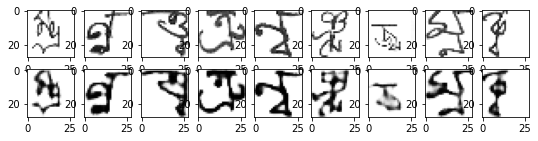

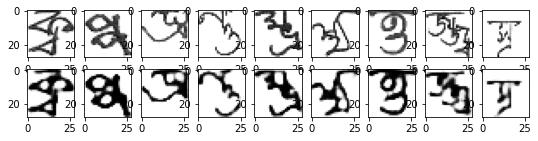

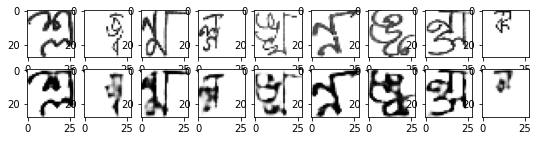

In [104]:
for k in range (0, num_epochs, 4):
    plt.figure(figsize = (9, 2))
    plt.gray()
    pictures = outputs[k][1].detach().numpy()
    recons = outputs[k][2].detach().numpy()
    for i, item in enumerate(pictures):
        if i >= 9:
            break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recons):
        if i >= 9:
            break
        plt.subplot(2, 9, 9+i+1) # row length + i + 1
        plt.imshow(item[0])

In [105]:
PATH = './models/autoencoder_model.pth'
# saving model
torch.save(net.state_dict(), PATH)
print("model was successfully saved")

model was successfully saved
